### Import Libraries

In [227]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [228]:
df = pd.read_csv('gold_monthly_csv.csv')

In [229]:
df

,Date,Price
0,1950-01,34.730
1,1950-02,34.730
2,1950-03,34.730
3,1950-04,34.730
4,1950-05,34.730
...,...,...
842,2020-03,1593.764
843,2020-04,1680.030
844,2020-05,1715.697
845,2020-06,1734.032


In [230]:
print(f"Date range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from - 1950-01 to 2020-07


In [231]:
date = pd.date_range(
                start = '1/1/1950',
                end = '8/1/2020',
                freq = 'M')

date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [232]:
df['month'] = date
df.drop('Date', axis = 1, inplace = True)

df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


### EDA & Visuals

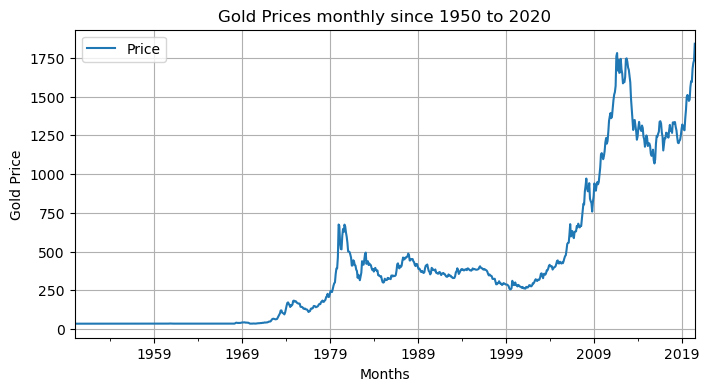

In [233]:
df.plot(figsize=(8,4))
plt.title('Gold Prices monthly since 1950 to 2020')
plt.xlabel('Months')
plt.ylabel('Gold Price')
plt.grid();

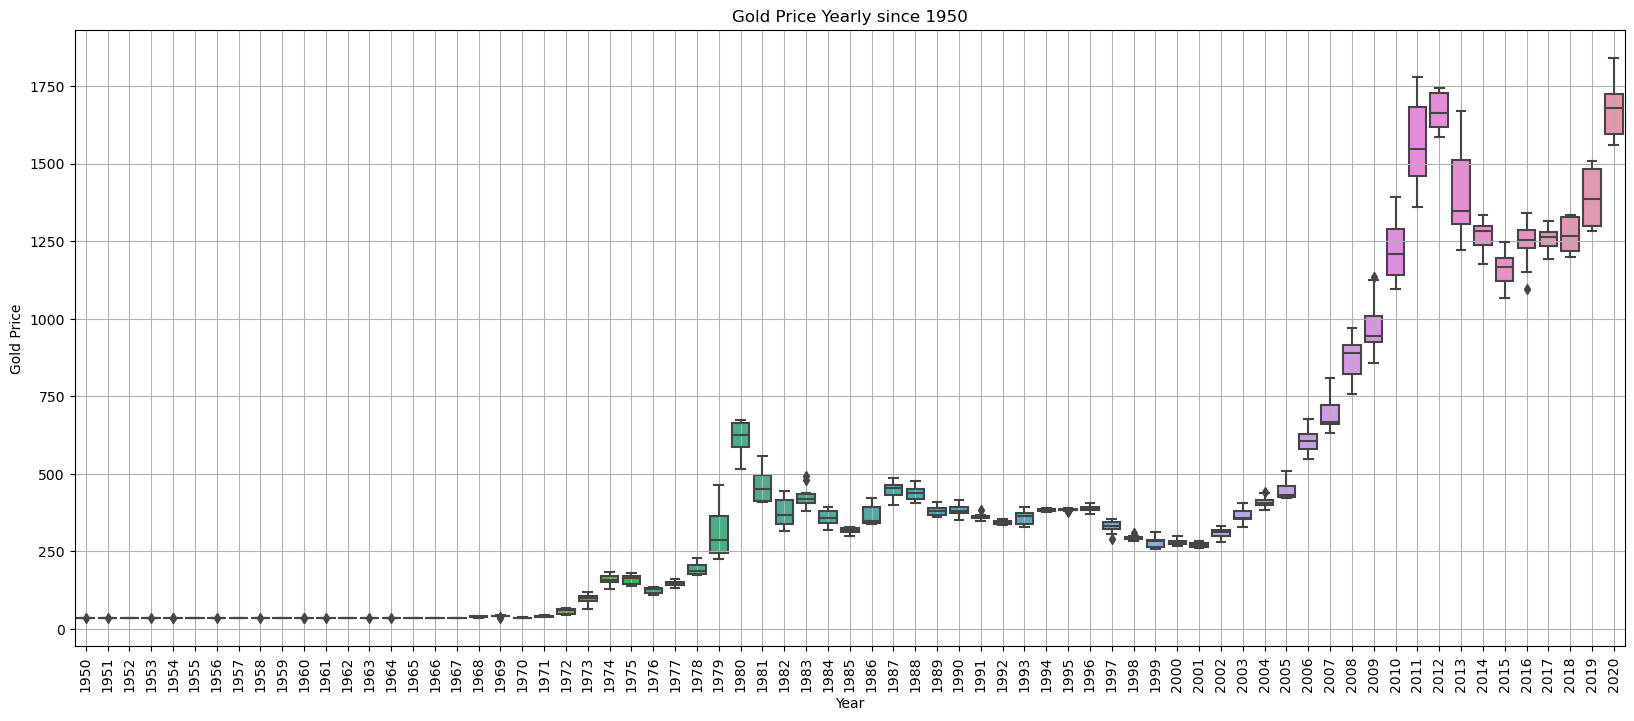

In [234]:
_, ax = plt.subplots(figsize=(20,8))
sns.boxplot(x = df.index.year, y = df.values[:,0], ax = ax)
plt.title('Gold Price Yearly since 1950')
plt.xlabel('Year')
plt.ylabel('Gold Price')
plt.xticks(rotation = 90)
plt.grid();


Text(0, 0.5, 'Gold Price')

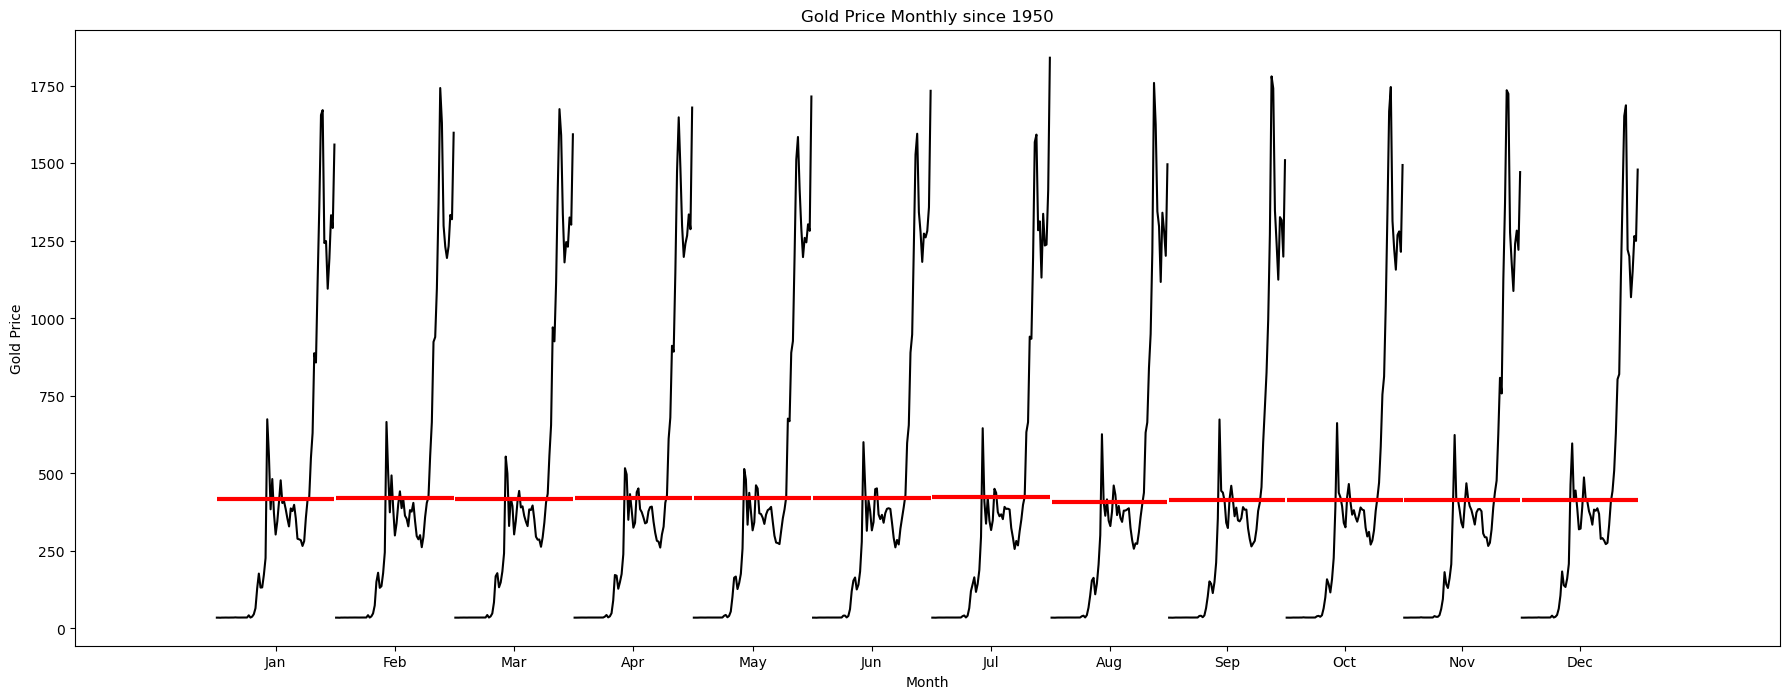

In [235]:
from statsmodels.graphics.tsaplots import month_plot

fig,ax = plt.subplots(figsize=(22,8))
month_plot(df, ylabel = 'Gold Price', ax = ax)
plt.title('Gold Price Monthly since 1950')
plt.xlabel('Month')
plt.ylabel('Gold Price')

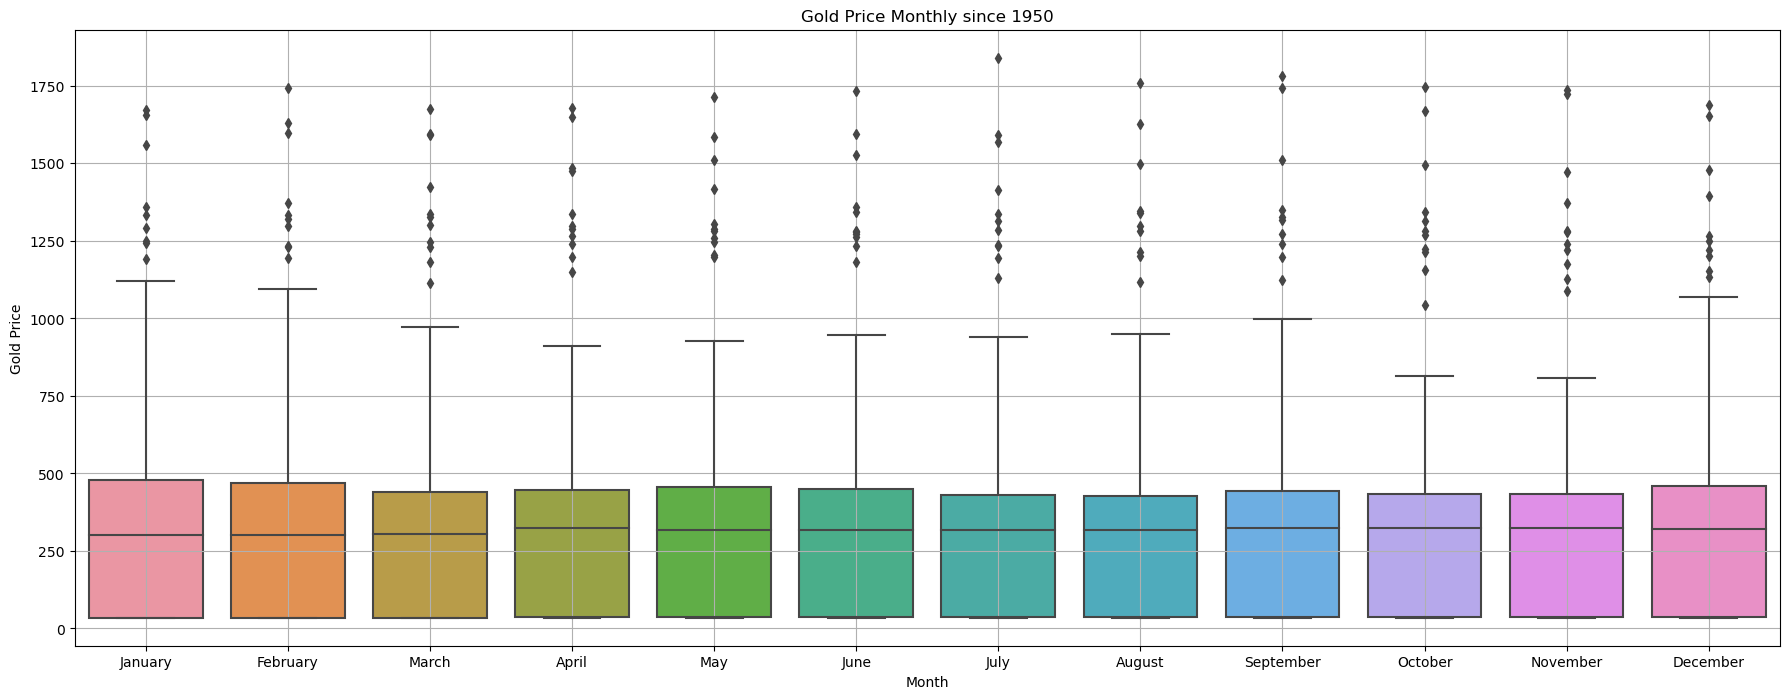

In [236]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(), y = df.values[:,0], ax = ax)
plt.title('Gold Price Monthly since 1950')
plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.grid();

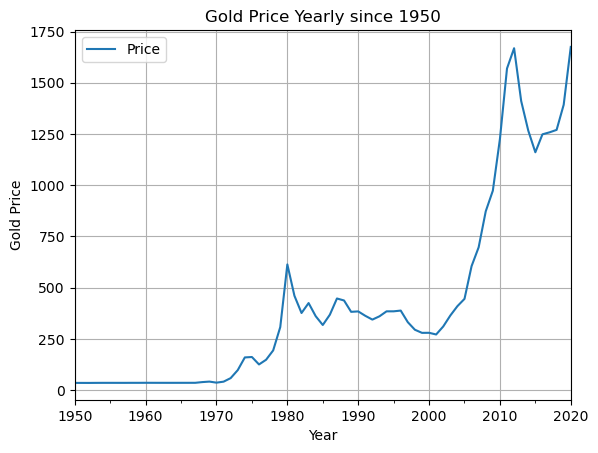

In [237]:
df_yearly_sum = df.resample('A').mean()

df_yearly_sum.plot();
plt.title('Gold Price Yearly since 1950')
plt.xlabel('Year')
plt.ylabel('Gold Price')
plt.grid();

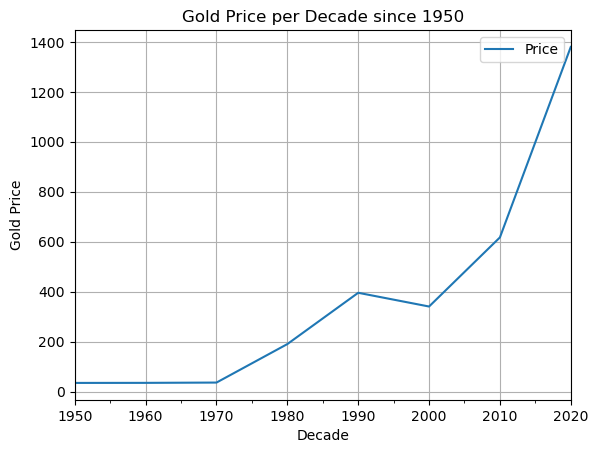

In [238]:
df_decade_sum = df.resample('10Y').mean()

df_decade_sum.plot();
plt.title('Gold Price per Decade since 1950')
plt.xlabel('Decade')
plt.ylabel('Gold Price')
plt.grid();

In [239]:
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price': 'Mean'}) 
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price': 'STD'}), 
                  left_index = True, right_index = True)

df_1['Cov_pct'] = ((df_1['STD']/df_1['Mean'])*100).round(2)
df_1.head()

,Mean,STD,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


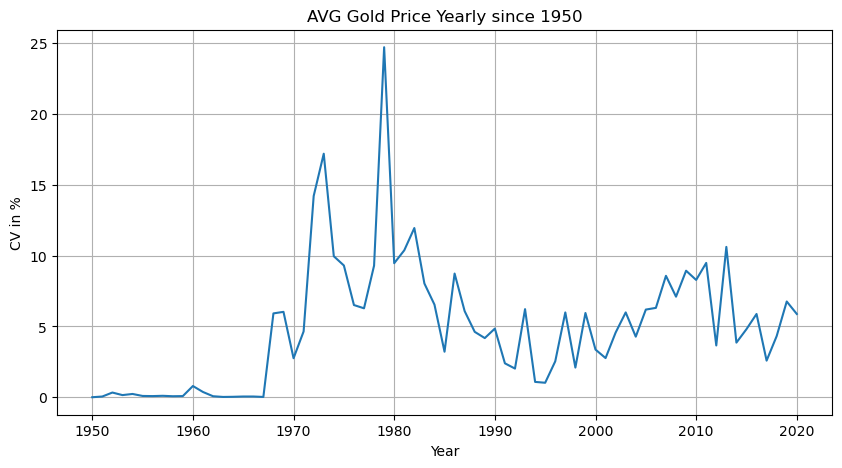

In [240]:
fig,ax = plt.subplots(figsize=(10,5))
df_1['Cov_pct'].plot()
plt.title('AVG Gold Price Yearly since 1950')
plt.xlabel('Year')
plt.ylabel('CV in %')
plt.grid()
plt.show()

### Splitting Data

In [241]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [242]:
print(train.shape, test.shape)

(792, 1) (55, 1)


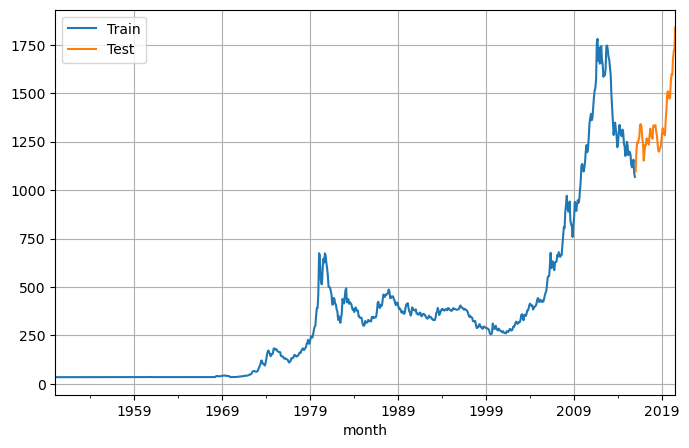

In [243]:
train['Price'].plot(figsize=(8,5))
test['Price'].plot(figsize=(8,5))
plt.grid()
plt.legend(['Train', 'Test'])
plt.show()

### LINEAR REGRESSION BASED ON TIME

In [244]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+ len(train)+1 for i in range(len(test))]

In [245]:
len(train_time), len(test_time)

(792, 55)

In [246]:
LR1_train = train.copy()
LR1_test = test.copy()

In [247]:
LR1_train['time'] = train_time
LR1_test['time'] = test_time

In [248]:
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

In [249]:
test_predictions_LR1 = lr.predict(LR_test[['time']])
LR1_test['forecast'] = test_predictions_LR1

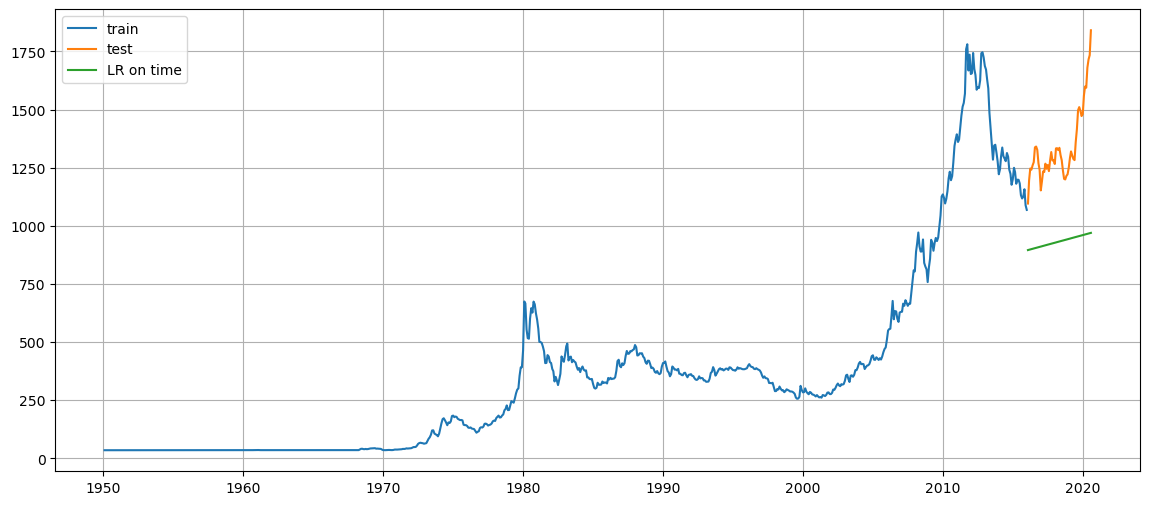

In [250]:
plt.figure(figsize=(14,6))
plt.plot(train['Price'], label = 'train')
plt.plot(test['Price'], label = 'test')
plt.plot(LR1_test['forecast'], label = 'LR on time')
plt.legend(loc = 'best')
plt.grid()

In [251]:
def mape(actual, pred):
    return round((np.mean(abs(actual - pred)/ actual))*100,2)

In [252]:
mape_LR1 = mape(test['Price'], LR1_test['forecast'])

In [253]:
mape_LR1

29.76

In [254]:
results = pd.DataFrame({'Test Mape %':[mape_LR1]}, index=['LROnTime'])

In [255]:
results

,Test Mape %
LROnTime,29.76


### NAIVE 

In [256]:
naive_train = train.copy()
naive_test = test.copy()

In [257]:
naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]

In [258]:
naive_test.head()

,Price,naive
month,,
2016-01-31,1095.655,1068.317
2016-02-29,1194.893,1068.317
2016-03-31,1246.312,1068.317
2016-04-30,1241.452,1068.317
2016-05-31,1259.755,1068.317


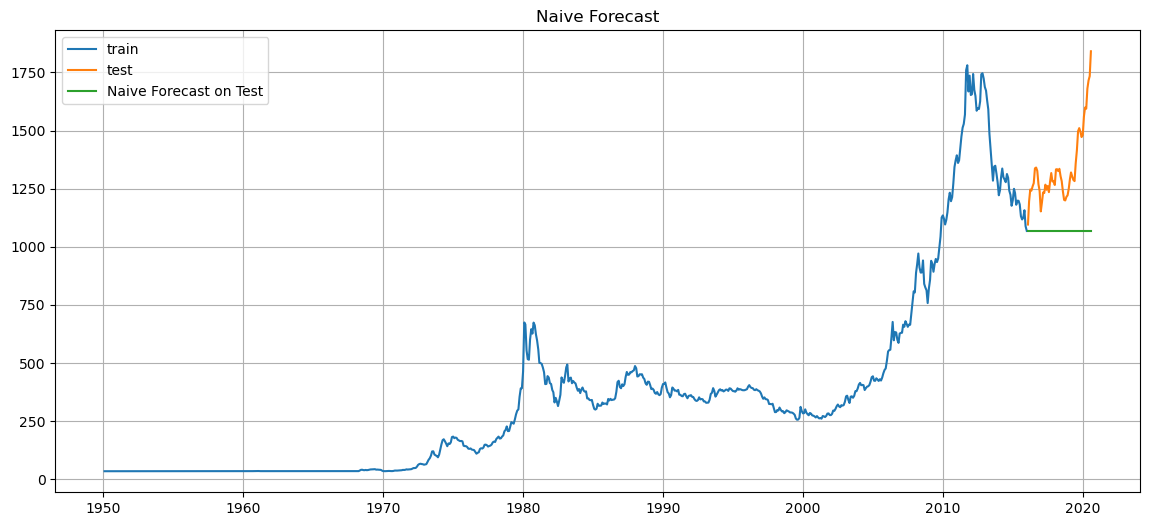

In [259]:
plt.figure(figsize=(14,6))
plt.plot(naive_train['Price'], label = 'train')
plt.plot(test['Price'], label = 'test')
plt.plot(naive_test['naive'], label = 'Naive Forecast on Test')
plt.legend(loc = 'best')
plt.title('Naive Forecast')
plt.grid()

In [260]:
mape_naive = mape(test['Price'], naive_test['naive'])

In [261]:
mape_naive

19.38

In [262]:
results_2 = pd.DataFrame({'Test Mape %':[mape_naive]}, index=['NaiveModel'])
results = pd.concat([results, results_2])
results

,Test Mape %
LROnTime,29.76
NaiveModel,19.38


## FINAL MODEL

In [263]:
final_model = ExponentialSmoothing(df,
                                  trend = 'additive',
                                  seasonal = 'additive').fit(smoothing_level = 0.4,
                                                            smoothing_trend = 0.3,
                                                             smoothing_seasonal= 0.6)

In [264]:
mape_fm = mape(df['Price'], final_model.fittedvalues)

In [265]:
mape_fm

17.24

In [266]:
results_3 = pd.DataFrame({'Test Mape %':[mape_fm]}, index=['Final Model Exponential Smoothing'])
results = pd.concat([results, results_3])
results

,Test Mape %
LROnTime,29.76
NaiveModel,19.38
Final Model Exponential Smoothing,17.24


In [267]:
predictions = final_model.forecast(steps = len(test))

In [268]:
pred_df = pd.DataFrame({'lower_CI': predictions - 1.96*np.std(final_model.resid, ddof=1),
                       'prediction': predictions,
                      'upper_CI': predictions + 1.96*np.std(final_model.resid, ddof=1)})

pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


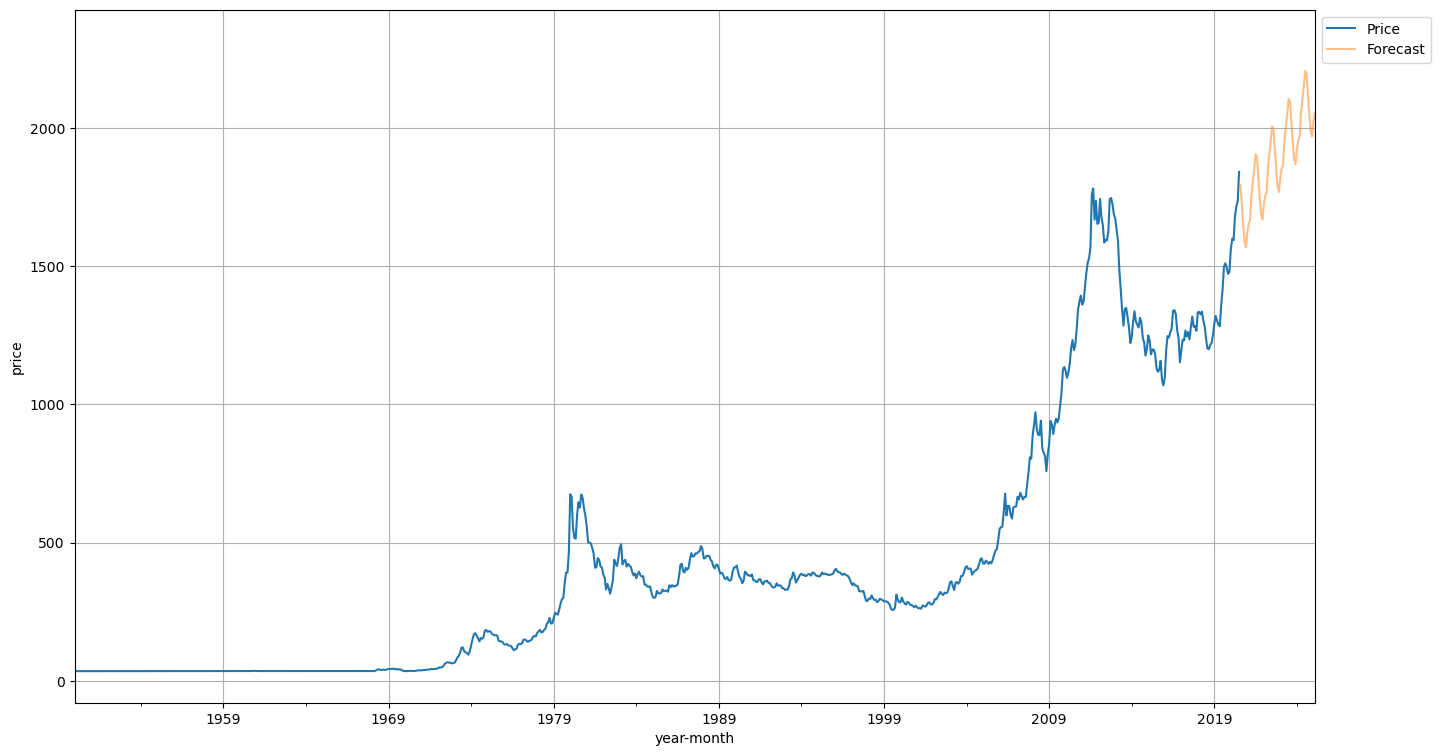

In [272]:
axis = df.plot(label='Actual', figsize=(16, 9))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='b', alpha=0.4)
axis.set_xlabel('year-month')
axis.set_ylabel('price')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid()
plt.show()


# no idea why filled upper&lower CI is not working